In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılacak cihaz:", device)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

DATA_DIR = r'C:\Users\Kardelen\Desktop\dlp\garbage-dataset'
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
print("Toplam örnek sayısı:", len(dataset))
class_names = dataset.classes
print("Sınıflar:", class_names)


Kullanılacak cihaz: cuda
Toplam örnek sayısı: 19762
Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [3]:
BATCH_SIZE = 32
targets = [s[1] for s in dataset.samples]

train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=targets, random_state=42
)
temp_targets = [targets[i] for i in temp_idx]
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_targets, random_state=42)

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE, shuffle=False)

print(f"Eğitim: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")


Eğitim: 13833, Val: 2964, Test: 2965


In [4]:
class CNNWithDropout(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.drop2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2,2)
        self.drop3 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2,2)
        self.drop4 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128*14*14, 512)
        self.drop_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop3(self.pool3(F.relu(self.conv3(x))))
        x = self.drop4(self.pool4(F.relu(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.drop_fc(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [5]:
NUM_TRIALS = 5
lr_candidates = 10**np.random.uniform(-5, -2, NUM_TRIALS)

best_lr = None
best_val_acc = 0.0
best_model_state = None

random_search_epochs = 5 

def train_epoch(model, train_loader, optimizer, criterion, scheduler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    return running_loss / len(train_loader.dataset), correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return val_loss / len(val_loader.dataset), correct / total


In [6]:
for i, lr in enumerate(lr_candidates):
    print(f"Deneme {i+1}/{NUM_TRIALS}: lr={lr:.6f}")
    model = CNNWithDropout().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=random_search_epochs)
    patience = 3; counter = 0; best_trial_val_acc = 0.0

    for epoch in range(random_search_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scheduler, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        print(f"  Epoch {epoch+1}/{random_search_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_trial_val_acc:
            best_trial_val_acc = val_acc
            counter = 0
            trial_best_state = model.state_dict()
        else:
            counter +=1
            if counter >= patience:
                break
    if best_trial_val_acc > best_val_acc:
        best_val_acc = best_trial_val_acc
        best_lr = lr
        best_model_state = trial_best_state
    del model, optimizer, criterion
    torch.cuda.empty_cache()

print(f"En iyi LR: {best_lr:.6f}, Best Val Acc: {best_val_acc:.4f}")


Deneme 1/5: lr=0.000147
  Epoch 1/5 | Train Loss: 1.7551 | Val Loss: 1.6880 | Train Acc: 0.3918 | Val Acc: 0.4359
  Epoch 2/5 | Train Loss: 1.4253 | Val Loss: 1.5364 | Train Acc: 0.5073 | Val Acc: 0.4717
  Epoch 3/5 | Train Loss: 1.2831 | Val Loss: 1.4095 | Train Acc: 0.5546 | Val Acc: 0.5138
  Epoch 4/5 | Train Loss: 1.1785 | Val Loss: 1.3398 | Train Acc: 0.5973 | Val Acc: 0.5469
  Epoch 5/5 | Train Loss: 1.1276 | Val Loss: 1.3279 | Train Acc: 0.6200 | Val Acc: 0.5509
Deneme 2/5: lr=0.000195
  Epoch 1/5 | Train Loss: 1.6722 | Val Loss: 1.6223 | Train Acc: 0.4224 | Val Acc: 0.4669
  Epoch 2/5 | Train Loss: 1.3438 | Val Loss: 1.4679 | Train Acc: 0.5362 | Val Acc: 0.5017
  Epoch 3/5 | Train Loss: 1.1976 | Val Loss: 1.4420 | Train Acc: 0.5900 | Val Acc: 0.4987
  Epoch 4/5 | Train Loss: 1.0752 | Val Loss: 1.3891 | Train Acc: 0.6388 | Val Acc: 0.5314
  Epoch 5/5 | Train Loss: 0.9893 | Val Loss: 1.3204 | Train Acc: 0.6653 | Val Acc: 0.5560
Deneme 3/5: lr=0.000154
  Epoch 1/5 | Train Loss: 1.

In [7]:
model = CNNWithDropout().to(device)
model.load_state_dict(best_model_state)
final_training_epochs = 20
final_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
final_optimizer = optim.Adam(model.parameters(), lr=best_lr)
final_criterion = nn.CrossEntropyLoss()
final_scheduler = lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=final_training_epochs)
patience = 3; counter = 0; best_final_val_acc = 0.0

for epoch in range(final_training_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, final_optimizer, final_criterion, final_scheduler, device)
    val_loss, val_acc = validate_epoch(model, val_loader, final_criterion, device)

    final_history['train_loss'].append(train_loss)
    final_history['val_loss'].append(val_loss)
    final_history['train_acc'].append(train_acc)
    final_history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_final_val_acc:
        best_final_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), 'best_final_model.pth')
    else:
        counter +=1
        if counter >= patience:
            print("Early stopping!")
            break

model.load_state_dict(torch.load('best_final_model.pth', weights_only=True))



Epoch 1 | Train Loss: 1.0720 | Val Loss: 1.2674 | Val Acc: 0.5732
Epoch 2 | Train Loss: 1.0015 | Val Loss: 1.1882 | Val Acc: 0.5995
Epoch 3 | Train Loss: 0.9290 | Val Loss: 1.1355 | Val Acc: 0.6211
Epoch 4 | Train Loss: 0.8571 | Val Loss: 1.0862 | Val Acc: 0.6319
Epoch 5 | Train Loss: 0.7826 | Val Loss: 1.1873 | Val Acc: 0.6070
Epoch 6 | Train Loss: 0.7221 | Val Loss: 1.0145 | Val Acc: 0.6582
Epoch 7 | Train Loss: 0.6534 | Val Loss: 1.0286 | Val Acc: 0.6592
Epoch 8 | Train Loss: 0.5985 | Val Loss: 0.9883 | Val Acc: 0.6785
Epoch 9 | Train Loss: 0.5362 | Val Loss: 0.9547 | Val Acc: 0.6940
Epoch 10 | Train Loss: 0.4796 | Val Loss: 0.9926 | Val Acc: 0.6845
Epoch 11 | Train Loss: 0.4308 | Val Loss: 0.9589 | Val Acc: 0.7014
Epoch 12 | Train Loss: 0.3939 | Val Loss: 0.9126 | Val Acc: 0.7217
Epoch 13 | Train Loss: 0.3550 | Val Loss: 0.9451 | Val Acc: 0.7146
Epoch 14 | Train Loss: 0.3264 | Val Loss: 0.9523 | Val Acc: 0.7159
Epoch 15 | Train Loss: 0.2971 | Val Loss: 0.9690 | Val Acc: 0.7223
Epoc

<All keys matched successfully>

In [8]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels, all_preds)
    return all_labels, all_preds, cm, f1_per_class, f1_macro, test_acc

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Tahmin Edilen Sınıf'); plt.ylabel('Gerçek Sınıf'); plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.show()


def plot_f1_per_class(f1_scores, class_names):
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, f1_scores, color='mediumseagreen')
    for i, score in enumerate(f1_scores):
        plt.text(i, score + 0.02, f'{score:.4f}', ha='center')
    plt.title('Sınıf Başına F1 Skoru'); plt.xlabel('Sınıf Adları'); plt.ylabel('F1 Skoru'); plt.ylim(0,1.0)
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

def plot_overall_metrics(test_acc, f1_macro):
    metrics = ['TEST Accuracy', 'Macro F1 Skoru']
    scores = [test_acc, f1_macro]
    plt.figure(figsize=(6,5))
    plt.bar(metrics, scores, color=['skyblue','lightcoral']); plt.ylim(0,1.0)
    for i, score in enumerate(scores):
        plt.text(i, score+0.02, f'{score:.4f}', ha='center', color='black')
    plt.title('Test Metrikleri'); plt.ylabel('Skor Değeri'); plt.tight_layout(); plt.show()

def plot_training_history(history):
    epochs = np.arange(1,len(history['train_loss'])+1)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
    plt.title('Eğitim & Val Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo', label='Training acc')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation acc')
    plt.title('Eğitim & Val Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
    plt.tight_layout(); plt.show()

def show_random_test_images(model, test_loader, device, class_names, num_samples=4):
    for images_batch, labels_batch in test_loader: break
    images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
    model.eval()
    with torch.no_grad():
        outputs_batch = model(images_batch)
    _, predicted_indices_batch = torch.max(outputs_batch, 1)
    random_indices = random.sample(range(len(images_batch)), num_samples)
    fig, axes = plt.subplots(1,num_samples,figsize=(12,3))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        img = images_batch[idx].cpu().numpy().transpose((1,2,0))
        mean = np.array([0.485,0.456,0.406]); std=np.array([0.229,0.224,0.225])
        img = np.clip(std*img + mean,0,1)
        true_label = class_names[labels_batch[idx].item()]
        pred_label = class_names[predicted_indices_batch[idx].item()]
        title_color = 'green' if true_label==pred_label else 'red'
        ax.set_title(f"P:{pred_label}\n(R:{true_label})", color=title_color)
        ax.imshow(img); ax.axis('off')
    plt.tight_layout(); plt.show()


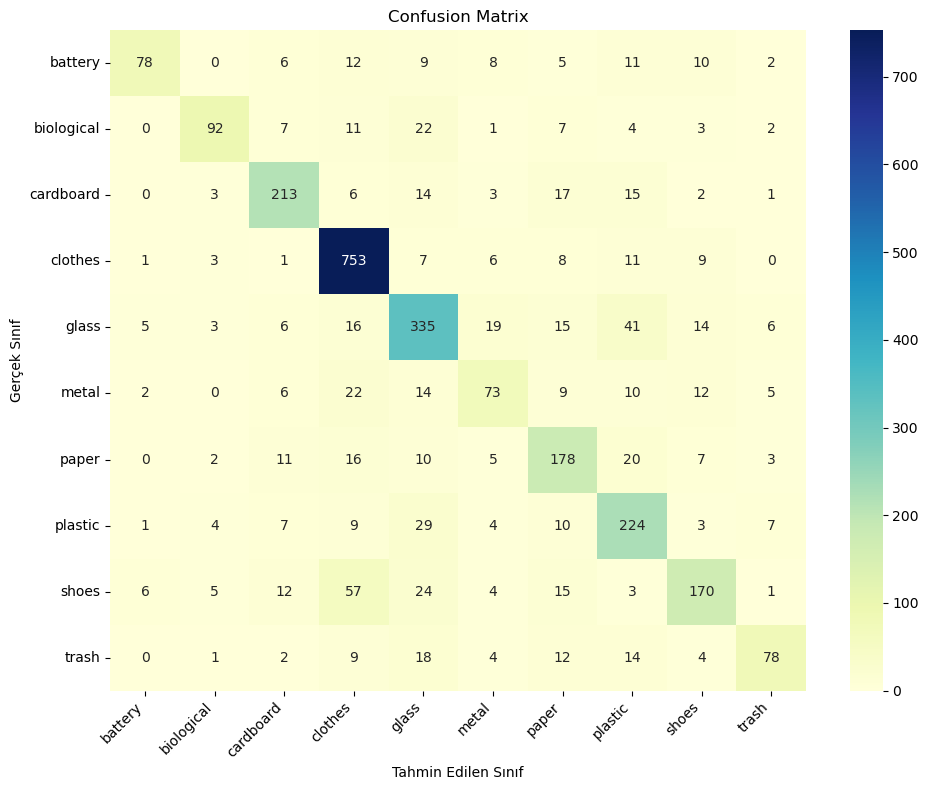

In [9]:
all_labels, all_preds, cm, f1_per_class, f1_macro, test_acc = evaluate_model(model, test_loader, device, class_names)

plot_confusion_matrix(cm, class_names)


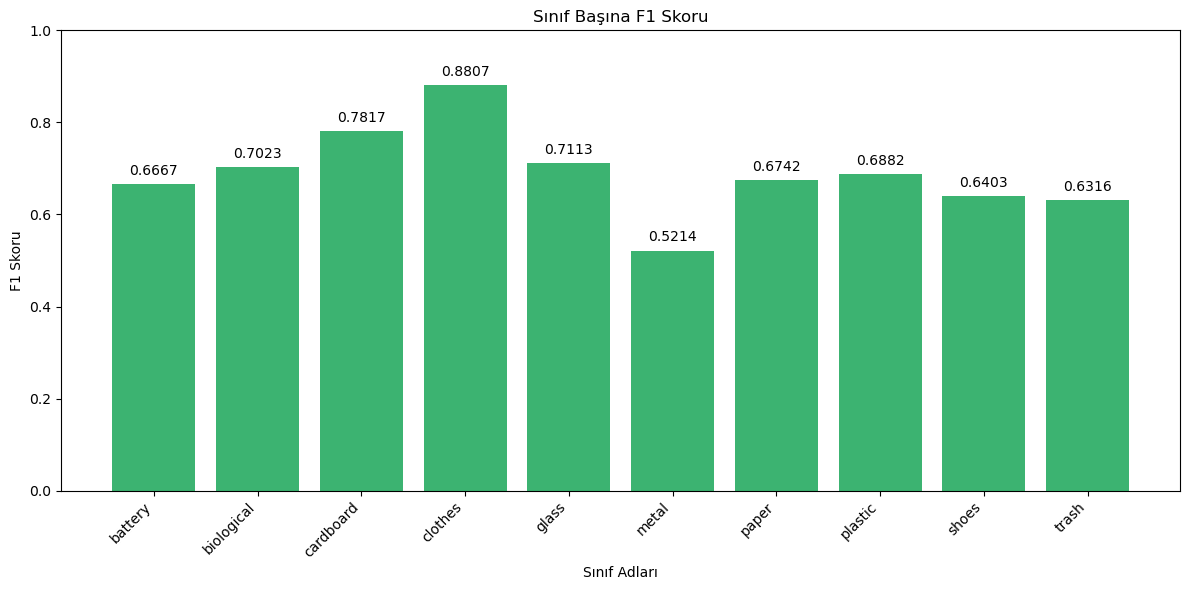

In [10]:
plot_f1_per_class(f1_per_class, class_names)


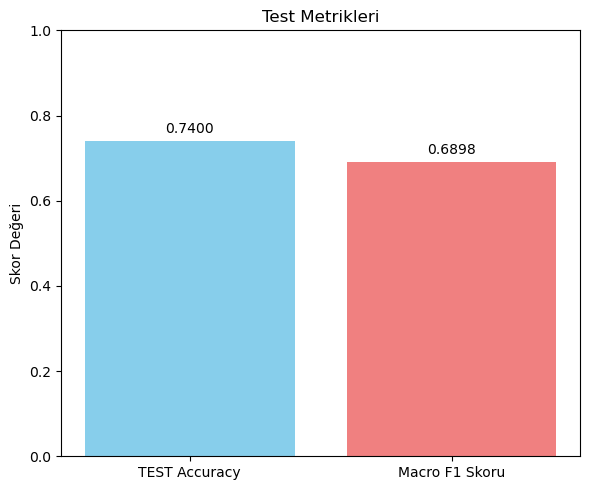

In [11]:
plot_overall_metrics(test_acc, f1_macro)


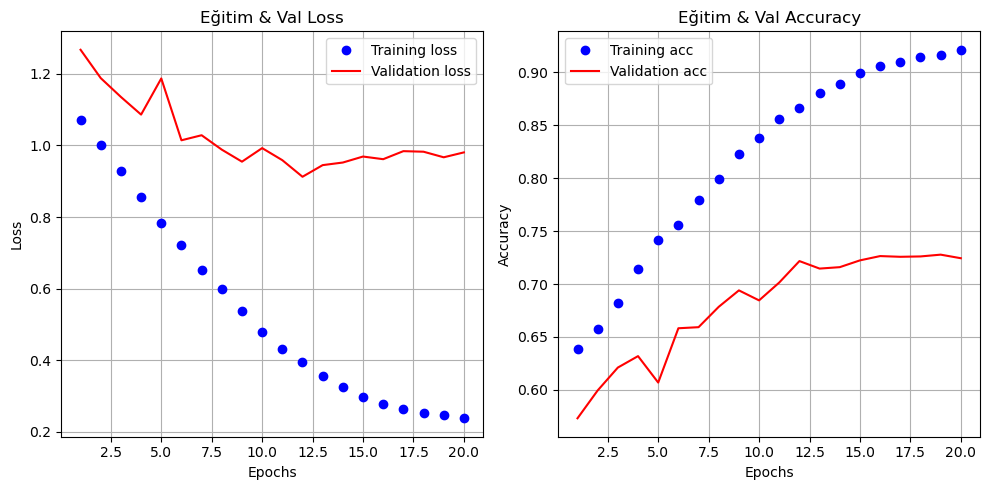

In [12]:
plot_training_history(final_history)


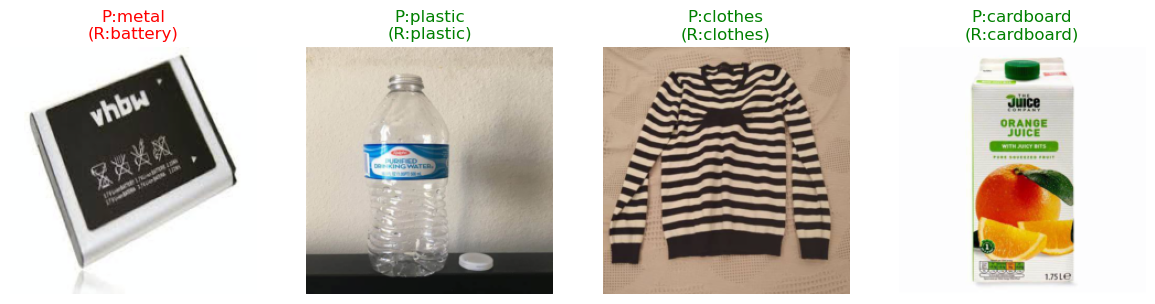

In [13]:
show_random_test_images(model, test_loader, device, class_names)